# Analisa A/B testing pada toko daring internasional

Suatu toko internasional ingin melakukan A/B testing untuk menguji perubahan terkait pengenalan sistem rekomendasi yang telah ditingkatkan. Dengan adanya sistem rekomendasi yang baru ini, diharapkan bahwa dalam kurun waktu 14 hari setelah pendaftaran, terdapat peningkatan dalam hal konversi ke tayangan halaman produk maupun ke keranjang belanja dengan peningkatan minimal 10%. Sampel yang digunakan adalah 15% dari pengguna baru dari kawasan Uni Eropa dengan jumlah peserta diharapkan berjumlah 6000 orang.

Tahapan dari kegiatan analisa ini adalah: pra pemrosesan, pengolahan data, analisis data eksploratif, A/B testing, dan ditutup dengan kesimpulan dan rekomendasi.

## Pra pemrosesan

### Pemanggilan library

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import math
from plotly import graph_objects as go
import datetime

### Pemanggiland dataset

In [57]:
marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

### Pengeksplorasian data awal

Pada dataset `marketing` terdapat kolom:
- `name` — nama event pemasaran
- `regions` — kawasan tempat kampanye iklan akan berlangsung
- `start_dt` — tanggal awal kampanye
- `finish_dt` — tanggal akhir kampanye

Pada dataset `users` terdapat kolom:
- `user_id`
- `first_date` — tanggal pendaftaran (sign up)
- `region`
- `device` — perangkat yang digunakan untuk mendaftar

Pada dataset `events` terdapat kolom:
- `user_id`
- `event_dt` — tanggal dan waktu peristiwa
- `event_name` — nama jenis peristiwa
- `details` — data tambahan terkait peristiwa tersebut (misalnya, jumlah total pesanan dalam USD untuk peristiwa purchase)

Pada dataset `participants` terdapat kolom:
- `user_id`
- `ab_test` — nama eksperimen
- `group` — kelompok eksperimen pengguna berasal


#### Pengeksplorasian dataset `marketing`

In [58]:
marketing.shape

(14, 4)

In [59]:
marketing.info()
marketing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,St. Patric's Day Promo,APAC,2020-03-17,2020-10-07
freq,1,4,1,1


In [60]:
marketing.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Dari dataset `marketing` dapat terlihat bahwa berisi data yang mengandung kapan terdapat promo - promo tertentu, lengkap dengan periode tanggal dan area apa saja yang termasuk ke dalam promo. Pada dataset ini akan diubah kolom `start_dt` dan `end_dt` dengan tipe data datetime.

#### Pengeksplorasian dataset `users`

In [61]:
users.shape

(58703, 4)

In [62]:
users.info()
users.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


,user_id,first_date,region,device
count,58703,58703,58703,58703
unique,58703,17,4,4
top,7227A0CFE993167C,2020-12-21,EU,Android
freq,1,6077,43396,26159


In [63]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [64]:
users.duplicated().sum()

0

Untuk dataset `users`, dapat dilihat bahwa berisi data yang menunjukan kapan pengguna mendaftar pertama kali ke dalam aplikasi. Dalam dataset `users` mencatat dari tanggal 7 Desember 2020 hingga 21 Desember 2021. Tipe data pada kolom `first_date` akan diubah menjadi datetime. Selain itu, dikarenakan pada A/B testing ini akan diuji untuk pelanggan yang berasal dari eropa, maka akan dijadikan sebagai acuan untuk memfilter pelanggan pada dataset lainnya

#### Pengeksplorasian dataset `events`

In [65]:
events.shape

(423761, 4)

In [66]:
events.info()
events.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


,details
count,60314.000000
mean,23.881219
std,72.228884
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


In [67]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Dari ringkasan dataset, dapat terlihat jumlah kolom `details` berbeda dibanding yang lain, yang mengindikasikan bahwa terdapat nilai yang hilang

In [68]:
events.isnull().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

Untuk mengetahui apa yang menyebabkan terdapat nilai hilang pada kolom `details`, akan dilihat rangkaian event apa saja yang memiliki nilai yang hilang

In [69]:
events[events['details'].isnull()]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

In [70]:
events.duplicated().sum()

0

Dari dataset `events` dapat terlihat bahwa kapan pelanggan melakukan aksi tertentu. Pada kolom `event_dt` akan diubah menjadi tipe data datetime dan untuk kolom `details`, karena terdapat nilai hilang dan nilai yang terisi merupakan jumlah pesanan yang dilakukan oleh pengguna, maka nilai yang hilang pada kolom `details` akan diisi menjadi 0

#### Pengeksplorasian dataset `participants`

In [71]:
participants.shape

(14525, 3)

In [72]:
participants.info()
participants.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


,user_id,group,ab_test
count,14525,14525,14525
unique,13638,2,2
top,5EC32E17A02C2131,A,interface_eu_test
freq,2,8214,10850


In [73]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [74]:
participants.duplicated().sum()

0

Pada dataset `participants` mengandung data peserta dan termasuk ke dalam grup apa. Untuk memudahkan analisa, akan dipindahkan kolom `group` ke dataset lainnya

### Kesimpulan Sementara

Dari pengeksplorasian data awal, didapat kesimpulan sebagai berikut:
- Kolom - kolom yang mengandung tanggal dan waktu akan diubah tipe datanya menjadi datetime
- Nilai yang hilang pada kolom `details` pada dataset `events` akan diisi dengan angka 0
- Dilakukan pemfilteran pengguna yang hanya berasal dari Eropa saja
- Dilakukan penambahkan grup pada dataset `events`

## Pemrosesan data

Selanjutnya akan dilakukan pemrosesan data

### Pengubahan tipe data & pengisian nilai yang hilang

Pertama akan dilakukan pengubahan tipe data

In [75]:
marketing['start_dt'] = marketing['start_dt'].astype('datetime64')
marketing['finish_dt'] = marketing['finish_dt'].astype('datetime64')
users['first_date'] = users['first_date'].astype('datetime64')
events['event_dt'] = events['event_dt'].astype('datetime64')

Selanjutnya akan dilakukan pengisian nilai yang hilang

In [76]:
events['details'].fillna('0', inplace=True)

### Pemfilteran pengguna

Selanjutnya akan dilakukan pemfilteran guna untuk memilih pengguna yang berada di Eropa.

In [77]:
eu_users = users[users['region'] == 'EU']['user_id']
eu_users

0        D72A72121175D8BE
2        2E1BF1D4C37EA01F
3        50734A22C0C63768
7        8942E64218C9A1ED
9        FFCEA1179C253104
               ...       
58698    1DB53B933257165D
58699    538643EB4527ED03
58700    7ADEE837D5D8CBBD
58701    1C7D23927835213F
58702    8F04273BB2860229
Name: user_id, Length: 43396, dtype: object

In [78]:
participants = participants[participants['user_id'].isin(eu_users)]
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


Selain itu, akan dilakukan pemfilteran dengan hanya mengambil peristiwa maksimal 14 hari setelah pendaftaran. Pertama disatukan tabel `users` dan `events`

In [79]:
events = events.merge(users[['user_id', 'first_date']], on='user_id')
events.head()

,user_id,event_dt,event_name,details,first_date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,E1BDDCE0DAFA2679,2020-12-09 06:21:35,purchase,9.99,2020-12-07
2,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,0,2020-12-07
3,E1BDDCE0DAFA2679,2020-12-09 06:21:35,login,0,2020-12-07
4,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07


Lalu akan ditambahkan kolom `cutoff_date` yakni 14 hari setelah melakukan pendaftaran

In [80]:
events['cutoff_date'] = events['first_date'] + datetime.timedelta(days=14)
events.head()

,user_id,event_dt,event_name,details,first_date,cutoff_date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,2020-12-21
1,E1BDDCE0DAFA2679,2020-12-09 06:21:35,purchase,9.99,2020-12-07,2020-12-21
2,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,0,2020-12-07,2020-12-21
3,E1BDDCE0DAFA2679,2020-12-09 06:21:35,login,0,2020-12-07,2020-12-21
4,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,2020-12-21


Lalu akan difilter event yang melewati tanggal cutoff

In [81]:
events = events.where(events['event_dt'] < events['cutoff_date'], np.nan)

### Memastikan bahwa tidak ada pengguna masuk ke dalam 2 grup

Setelah melakukan pemfilteran pengguna apa saja yang berada di Eropa, akan dipastikan apakah data `ab_users` mengandung pengguna yang masuk ke dalam 2 grup

In [82]:
group_ab_users = participants.groupby('user_id')['group'].unique().reset_index()
double_group = group_ab_users[group_ab_users['group'].str.len() > 1].reset_index(drop=True)
double_group.head()

,user_id,group
0,0082295A41A867B5,"[A, B]"
1,00E68F103C66C1F7,"[A, B]"
2,02313B9E82255F47,"[A, B]"
3,04F2CF340B4F3822,"[A, B]"
4,051D59BC38C3B3AA,"[A, B]"


In [83]:
print('Jumlah pengguna yang termasuk ke dalam 2 grup:', len(double_group))
print('Persentase pengguna yang termasuk ke dalam 2 grup:{:.2%}'.format(len(double_group)/group_ab_users.shape[0]))

Jumlah pengguna yang termasuk ke dalam 2 grup: 441
Persentase pengguna yang termasuk ke dalam 2 grup:3.28%


Terdapat 441 pengguna A/B testing yang masuk ke dalam 2 grup atau 3,28% dari keseluruhan data. Pengguna ini akan difilter untuk menghindari kerancuan

In [84]:
participants = participants[~participants['user_id'].isin(double_group['user_id'])].reset_index(drop=True)

### Pembuatan dataset baru

Dengan mendapatkan pengguna yang berasal dari Eropa, tidak melebih 14 hari setelah pendaftaran, dan tidak termasuk ke dalam 2 grup, maka dataset `events`, dan `participants` bisa digabungkan menjadi satu dataset baru

In [85]:
user_ab_events = events.merge(participants, on='user_id')
user_ab_events.head()

,user_id,event_dt,event_name,details,first_date,cutoff_date,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020-12-21,B,interface_eu_test
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-07,2020-12-21,B,interface_eu_test
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-07,2020-12-21,B,interface_eu_test
3,96F27A054B191457,2020-12-07 04:02:41,product_page,0,2020-12-07,2020-12-21,B,interface_eu_test
4,96F27A054B191457,2020-12-08 09:43:18,product_page,0,2020-12-07,2020-12-21,B,interface_eu_test


Lalu akan dipastikan bahwa data tidak mengandung pengguna yang tidak termasuk ke dalam grup apapun

In [86]:
user_ab_events[user_ab_events['group'].str.len() < 1]['user_id'].count()

0

In [87]:
user_ab_events['ab_test'].value_counts()

interface_eu_test          72978
recommender_system_test    19348
Name: ab_test, dtype: int64

Karena akan dilihat hasil A/B testing yang dikerjakan oleh pendahulu, maka akan dilakukan pemfilteran untuk mengambil A/B testing untuk recommender_system_test

In [88]:
ab_test_rec = user_ab_events[user_ab_events['ab_test'] == 'recommender_system_test']
ab_test_rec.head()

,user_id,event_dt,event_name,details,first_date,cutoff_date,group,ab_test
9,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-21,A,recommender_system_test
10,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-07,2020-12-21,A,recommender_system_test
11,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,0,2020-12-07,2020-12-21,A,recommender_system_test
12,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,0,2020-12-07,2020-12-21,A,recommender_system_test
13,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,0,2020-12-07,2020-12-21,A,recommender_system_test


### Kesimpulan

Pada tahap pemrosesan data, telah dilakukan kegiatan sebagai berikut:
- Pengubahan tipe data pada kolom yang menggandung tanggal dan waktu
- Pengisian pada nilai yang hilang
- Pemfilteran pengguna yang hanya berasal pada Eropa
- Memasikan bahwa tidak ada pengguna yang termasuk ke dalam 2 grup
- Pembuatan dataset baru yang berisi pengguna yang termasuk ke dalam pengujian A/B testing dan event yang dilakukan

## Analisis data eksploratif

Setelah dilakukan pemrosesan data agar data semakin mudah untuk dilakukan pemrosesan, akan dilakukan analisis data eksploratif

### Konversi pada berbagai tahapan corong

Pertama adalah mengecek konversi yang ada pada berbagai tahapan corong

In [89]:
event_funnel = ab_test_rec.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
event_funnel

event_name
login           3039
product_page    1907
purchase         955
product_cart     900
Name: user_id, dtype: int64

In [90]:
(event_funnel / len(ab_test_rec['user_id'].unique())).map('{:,.2%}'.format)

event_name
login           99.97%
product_page    62.73%
purchase        31.41%
product_cart    29.61%
Name: user_id, dtype: object

Dapat terlihat bahwa hampir 100% pengguna melakukan login ke halaman utama, lalu diikuti oleh pengguna masuk ke halaman produk sebesar 63%, lalu diikuti oleh halaman pembayaran sebesar 31% dan halaman keranjang belanja sebesar 30%. Dalam corong marketing, umumnya jalurnya adalah pengguna masuk (login), pengguna menuju halaman produk (product_page), pengguna ke keranjang belanja (product_cart), dan pengguna melakukan transaksi (purchase). Namun jumlah konversi pada keranjang belanja lebih sedikit dibandingkan dengan transaksi. Terdapat kemungkinan bahwa pada halaman produk, terdapat fitur untuk langsung melakukan transaksi, sehingga pengguna bisa melewati keranjang belanja.

In [91]:
fig = go.Figure(go.Funnel(
    y=event_funnel.reset_index()['event_name'][:3],
    x=event_funnel.reset_index()['user_id'][:3],
    textinfo="value + percent previous"
))
fig.show()

Dengan jumlah pengguna yang melakukan pembelian lebih banyak dibandingkan dengan pengguna yang menuju keranjang belanja, maka corong peristiwa nya hanya terdapat 3 tahapan, yakni login, product_page, dan purchase. Dapat dilihat bahwa penurunan jumlah pengguna terbanyak berada pada ketika pengguna dari login ke halaman produk

### Jumlah peristiwa per pengguna pada seluruh sampel

Selanjutnya akan dilihat jumlah peristiwa per pengguna pada seluruh sampel. Pertama dilihat untuk keseluruhan sampel

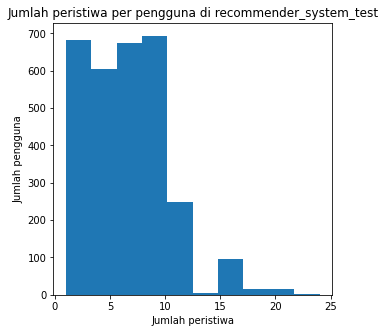

In [92]:
plt.figure(figsize=(5,5))

events_per_user_rec = ab_test_rec.groupby('user_id')['event_name'].count().sort_values(ascending=False)
plt.hist(events_per_user_rec, bins=10)
plt.title('Jumlah peristiwa per pengguna di recommender_system_test')
plt.xlabel('Jumlah peristiwa')
plt.ylabel('Jumlah pengguna')

plt.show()

Cukup banyak yang berada kurang dari 10 peristiwa apabila dilihat dari grafik. Selanjutnya akan dilihat untuk per sampel

In [93]:
a_events_rec = ab_test_rec[ab_test_rec['group'] =='A']
b_events_rec = ab_test_rec[ab_test_rec['group'] =='B']

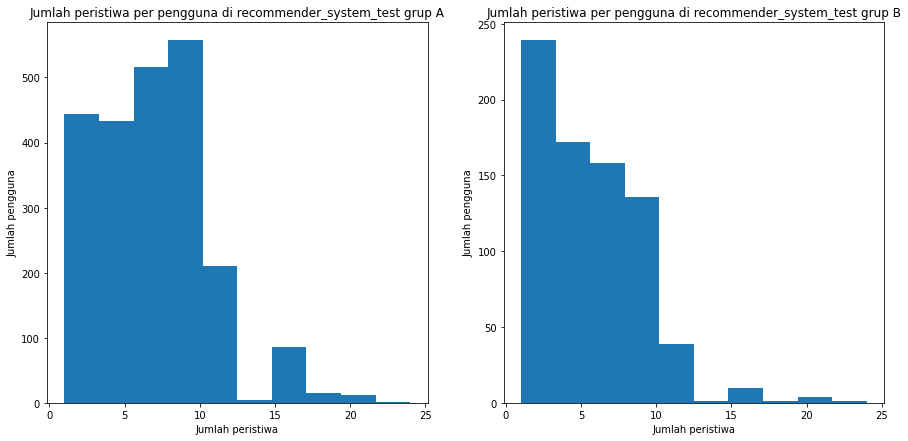

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes = axes.reshape(-1)

events_per_user_rec_a = a_events_rec.groupby('user_id')['event_name'].count().sort_values(ascending=False)
axes[0].hist(events_per_user_rec_a, bins=10)
axes[0].set_title('Jumlah peristiwa per pengguna di recommender_system_test grup A')
axes[0].set_xlabel('Jumlah peristiwa')
axes[0].set_ylabel('Jumlah pengguna')

events_per_user_rec_b = b_events_rec.groupby('user_id')['event_name'].count().sort_values(ascending=False)
axes[1].hist(events_per_user_rec_b, bins=10)
axes[1].set_title('Jumlah peristiwa per pengguna di recommender_system_test grup B')
axes[1].set_xlabel('Jumlah peristiwa')
axes[1].set_ylabel('Jumlah pengguna')

plt.show()

Untuk recommender_system_test terdapat perbedaan distribusi jumlah peristiwa per pengguna, dengan pada grup A mayoritas terdapat 10 peristiwa, sedangkan untuk grup B mayoritas terdapat kurang dari 5 peristiwa. Sehingga dapat dikatakan bahwa jumlah peristiwa per pengguna antar sampel tidak seimbang

### Pengguna yang berada pada 2 sampel

Selanjutnya akan dilihat apakah terdapat pengguna yang berada pada 2 sampel A/B testing

In [95]:
df = user_ab_events.groupby('user_id')['ab_test'].unique().reset_index()
double_group_1 = df[df['ab_test'].str.len() > 1].reset_index(drop=True)
double_group_1.shape

(446, 2)

Terdapat 446 pengguna yang berada pada 2 sampel. 

### Jumlah peristiwa per hari

Selanjutnya akan dilihat jumlah peristiwa masing - masing grup per hari

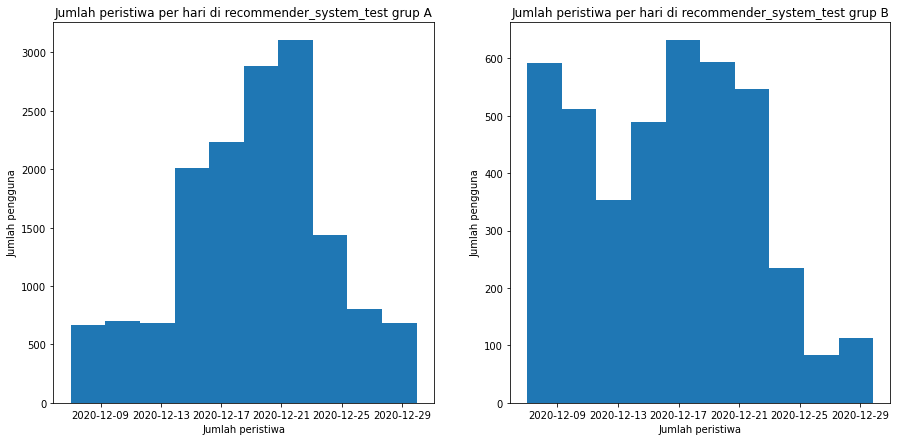

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes = axes.reshape(-1)

axes[0].hist(x=a_events_rec['event_dt'], bins=10)
axes[0].set_title('Jumlah peristiwa per hari di recommender_system_test grup A')
axes[0].set_xlabel('Jumlah peristiwa')
axes[0].set_ylabel('Jumlah pengguna')

axes[1].hist(x=b_events_rec['event_dt'], bins=10)
axes[1].set_title('Jumlah peristiwa per hari di recommender_system_test grup B')
axes[1].set_xlabel('Jumlah peristiwa')
axes[1].set_ylabel('Jumlah pengguna')

plt.show()

Dari jumlah peristiwa per hari, dapat terlihat bahwa pesebaran peristiwa pada recommender_system_test antara grup A dan grup B berbeda secara signifikan. Pada grup A mayoritas data berada pada setelah tanggal 21 Desember 2020, sedangkan pada grup B mayoritas data berada pada sebelum tanggal 21 Desember 2020

### Ciri - ciri khusus lainnya

Selain itu, data diharapkan mengambil 15% pengguna baru dari kawasan Eropa dan minimal 6000 peserta, akan dilihat pada kedua sampel 

In [97]:
print('Jumlah pengguna baru dari Eropa:', users[users['region'] == 'EU']['user_id'].nunique())
print('Jumlah pengguna baru pada recommender_system_test:', ab_test_rec['user_id'].nunique())
print('Presentase jumlah pengguna baru pada recommender_system_test:{:.2%}'.format(ab_test_rec['user_id'].nunique()/users[users['region'] == 'EU']['user_id'].nunique()))

Jumlah pengguna baru dari Eropa: 43396
Jumlah pengguna baru pada recommender_system_test: 3040
Presentase jumlah pengguna baru pada recommender_system_test:7.01%


Dapat dilihat bahwa jumlah audiens pada recommender_system_test berjumlah 3040 yang hanya merepresentasikan 7% dari pengguna baru dari seluruh Eropa. Jumlah ini jauh lebih kecil dibandingkan apa yang diharapkan dari A/B testing ini, yakni 15% dari pengguna seluruh Eropa dengan jumlah minimum 6000 peserta.

## A/B Testing

### Hasil A/B testing

Sebelum dilakukan z-test untuk menguji perbedaan statistik antar proporsi, hasil dari data menunjukan banyak data yang kurang baik. Contohnya adalah jumlah peserta yang melakukan transaksi lebih besar dibandingkan peserta yang masuk ke keranjang belanja, peserta yang masuk baik grup A dan B maupun yang masuk kedalam 2 jenis sampel (recommender_system_test dan interface_eu_test), dan distribusi grup pada recommender_system_test, baik jumlah peristiwa per pengguna dan peristiwa per tanggal yang tidak seimbang. Kedepannya dipastikan bahwa tidak ada data yang termasuk ke dalam 2 grup dan distribusi data yang mirip antar kedua grup. Selain itu, pastikan bahwa jumlah pengguna yang masuk ke dalam pengujian telah mencapai jumlah minimum yang telah ditetapkan

### Uji Z untuk menguji perbedaan statistik antara kelompok kontrol dan kelompok uji

Selanjutnya akan dilakukan uji Z untuk menguji perbedaan statistik antara kelompok kontrol dan kelompok uji. Dikarenakan terdapat 2 sampel, akan dilihat untuk kedua sampel. Pertama untuk recommender_system_test dengan grup kontrol adalah A dan grup uji adalah B, hipotesis nol dan alternatifnya sebagai berikut:
- H0 (hipotesis nol): Tidak ada perbedaan konversi antara grup kontrol dan grup uji
- H1 (hipotesis alternatif): Terdapat perbedaan konversi antara grup kontrol dan grup uji

In [99]:
users_per_group_rec = ab_test_rec.pivot_table(index='event_name',
                                      values='user_id',
                                      columns='group',
                                      aggfunc='nunique').sort_values(by='A', ascending=False)
users_per_group_rec

group,A,B
event_name,,
login,2279,760
product_page,1476,431
purchase,734,221
product_cart,686,214


In [100]:
total_users_group_rec = ab_test_rec.pivot_table(index='group',
                                        values='user_id',
                                        aggfunc='nunique')
total_users_group_rec

,user_id
group,
A,2279
B,761


Untuk memudahkan dalam melihat perbedaan signifikansi serta memudahkan dalam A/B test untuk kedepannya, akan dibuatkan sebuah fungsi. Tidak lupa dikarenakan ingin melihat perbedaan sebesar 10%, maka nilai signifikansi alpha sebesar 0,1

In [101]:
def z_test (success_1, success_2, trial_1, trial_2, alpha):
    p1 = success_1/trial_1 #proporsi sukses grup 1
    p2 = success_2/trial_2 #proporsi sukses grup 2
    p_total = (success_1 + success_2) / (trial_1 + trial_2) #proporsi sukses akumulasi 2 grup
    
    z_value = (p1 - p2) / (math.sqrt(p_total * (1 - p_total) * (1/trial_1 + 1/trial_2)))
    
    distr = st.norm(0,1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Nilai batas signifikansi (alpha):', alpha)
    print('Nilai p:', p_value)
    
          
    if (p_value < alpha):
        print('Kita menolak hipotesis nol')
    else:
        print("Kita tidak dapat menolak hipotesis nol")

In [102]:
#Pengujian fungsi
alpha_1 = 0.1
z_test(users_per_group_rec.loc['login', 'A'],
       users_per_group_rec.loc['login', 'B'],
       total_users_group_rec.loc['A'],
       total_users_group_rec.loc['B'],
       alpha_1)

Nilai batas signifikansi (alpha): 0.1
Nilai p: [0.08348432]
Kita menolak hipotesis nol


In [103]:
#Pembuatan fungsi untuk melakukan uji perbedaan signifikansi statistik untuk masing - masing kegiatan
def check_event_hypothesis(users_per_group, total_users_group, event, group_1, group_2, alpha):
    
    print(f'event {event} group {group_1}')
    print(f'event {event} group {group_2}')
    
    z_test(users_per_group.loc[event, group_1],
       users_per_group.loc[event, group_2],
       total_users_group.loc[group_1],
       total_users_group.loc[group_2],
          alpha)

In [104]:
for event in users_per_group_rec.index:
    check_event_hypothesis(users_per_group_rec, total_users_group_rec, event, 'A', 'B', alpha_1)
    print('------------------------------')

event login group A
event login group B
Nilai batas signifikansi (alpha): 0.1
Nilai p: [0.08348432]
Kita menolak hipotesis nol
------------------------------
event product_page group A
event product_page group B
Nilai batas signifikansi (alpha): 0.1
Nilai p: [5.92700568e-05]
Kita menolak hipotesis nol
------------------------------
event purchase group A
event purchase group B
Nilai batas signifikansi (alpha): 0.1
Nilai p: [0.10324356]
Kita tidak dapat menolak hipotesis nol
------------------------------
event product_cart group A
event product_cart group B
Nilai batas signifikansi (alpha): 0.1
Nilai p: [0.30021918]
Kita tidak dapat menolak hipotesis nol
------------------------------


Dari hasil Z-test untuk menguji perbedaan statistik dengan perbedaan signifikansi sebesar 10%, didapat bahwa pada recommender_system_test, untuk login dan halaman produk tidak ada perbedaan konversi antara grup kontrol dengan grup uji. Sedangkan pada halaman transaksi dan keranjang produk terdapat perbedaan konversi antara grup kontrol dengan grup uji.

## Kesimpulan & rekomendasi

Telah dilakukan kegiatan analisa dan A/B testing, dengan didapatkan kesimpulan sebagai berikut:
- Terdapat 4 dataset, dengan data yang digunakan hanya 3 dari 4 dataset
- Dilakukan pemrosesan data, seperti pengubahan tipe data, pemrosesan nilai yang hilang, pemfilteran data, dll.
- Corong peristiwa yang dihasilkan berbeda, dengan jumlah pelanggan yang melakukan transaksi lebih banyak dibandingkan pelanggan yang masuk ke keranjang belanja. 
- Jumlah pelanggan berkurang terbanyak saat pengunjung ingin mengunjungi halaman produk
- Pada sampel recommender_system_test, terdapat perbedaan distribusi antara grup kontrol dan grup uji, baik itu jumlah peristiwa per pengguna maupun jumlah peristiwa per tanggal. Sedangkan pada interface_eu_test distribusi antara grup kontrol dengan grup uji hampir sama
- Hasil uji z menunjukan tidak ada perbedaan konversi antara grup kontrol dan grup uji pada saat pengunjung menuju halaman utama maupun pengunjung menuju ke halaman produk. Namun terdapat perbedaan konversi antara grup kontrol dengan grup uji pada saat pengunjung menuju ke halaman keranjang produk dan pengunjung melakukan transaksi

Selain itu, apabila ingin melakukan uji A/B testing lagi, terdapat beberapa rekomendasi:
- Hanya mengirim data yang relevan saja (seperti pengguna dari region tertentu)
- Memastikan tidak ada pengguna yang masuk ke dalam 2 grup ataupun 2 sampel
- Memastikan bahwa tidak ada lagi data pengguna yang loncat dari halaman produk ke transaksi
- Memastikan distribusi data antar kedua grup sama
- Jumlah pengguna juga harus mencapai target minimum yang telah ditetapkan